# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from prettytable import PrettyTable

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(os.getcwd()+'/Assignment/database.sqlite')

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 70000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
filtered_data['Score'] = filtered_data["Score"].map(partition)
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (70000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(62864, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.80571428571429

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible. Hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(62862, 10)


1    52600
0    10262
Name: Score, dtype: int64

## [2.4] Upsampling the data for a balanced dataset

In [10]:
# final_neg = final[final.Score==0]
# final_neg_upsampled = resample(final_neg, replace=True, n_samples=38000, random_state=1)

In [11]:
# final = pd.concat([final[final.Score==1], final_neg_upsampled])
# final.shape

## [2.5] Sorting the data according to Time

In [12]:
final = final.sort_values(by="Time", ascending=True).reset_index(drop=True)

In [13]:
#Verifying the data
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
2,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
3,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...
4,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan..."


In [14]:
final.tail(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
62857,47562,B004M0Y8T8,A2QJS6MHTIFSRI,Georgie,0,0,1,1351209600,Sleeping a lot better,Hubby and I (both 63) have been drinking about...
62858,20930,B001L1MKLY,A38XYFHXEUNUW6,bleaufire,0,0,1,1351209600,Yummy & Subtle,Just made my first pot of this wonderful coffe...
62859,32932,B001P05K8Q,A3L0B5NBTQ7ZHO,Julie,0,0,1,1351209600,Great results but they stink,We originally purchased these chews from our v...
62860,7178,B004OQLIHK,AKHQMSUORSA91,Pen Name,0,0,1,1351209600,Delicious!,I have ordered these raisins multiple times. ...
62861,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
from bs4 import BeautifulSoup

def cleanhtml(dirtytext):
    return BeautifulSoup(dirtytext, "html.parser").get_text()

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
#Storing the stopwords of english
stopwords = set(nltk.corpus.stopwords.words("english"))
# stopwords

In [18]:
#function to remove stopwords, removing alphaneumeric words and lowering caps
def secondClean(text):
    filtered_words = []
    text = re.sub('[^A-Za-z]+', ' ', text)
    for x in text.split():
        if x not in stopwords and x.isalpha():
            filtered_words.append(x.lower())
    return " ".join(filtered_words).strip()

In [19]:
#Testing function:
x = cleanhtml("<div><a>XYZZYSPOON!</a></div>")
print(x)
print(secondClean("[Auld] [Lang Syne"))

XYZZYSPOON!
auld lang syne


In [20]:
#Preprocessing the reviews
final["CleanedText"] = final["Text"].apply(lambda x:cleanhtml(x))
final["CleanedText"] = final["CleanedText"].apply(lambda x: decontracted(x))
final["CleanedText"] = final["CleanedText"].apply(lambda x: secondClean(x))

In [21]:
final["CleanedText"].values[0]

'this really good idea final product outstanding i use decals car window everybody asks bought decals made two thumbs'

In [22]:
final["Text"].values[0]

'This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!'

# [4] Truncated SVD with TFIDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
X = final["CleanedText"].values[:50000]
X.shape

(50000,)

In [25]:
tfidf = TfidfVectorizer(use_idf=True)
X_tfidf = tfidf.fit_transform(X)

In [26]:
from sklearn.preprocessing import StandardScaler

X_tfidf = StandardScaler(with_mean=False).fit_transform(X_tfidf)

In [27]:
#Feature names:
feat_names = tfidf.get_feature_names()

#Idf score of features
feat_idf = tfidf.idf_

df = pd.DataFrame({"Features": feat_names, "IDF":feat_idf})
df = df.sort_values("IDF", ascending=False)[:2000]

In [28]:
# https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix?noredirect=1&lq=1
# https://cs224d.stanford.edu/lecture_notes/notes1.pdf
# co-occurence matrix
co_oc_matrix = np.zeros((len(df), len(df)))
df_temp = pd.DataFrame(co_oc_matrix, index = df["Features"], columns = df["Features"])
df_temp.shape

(2000, 2000)

In [29]:
window_size = 4
for sent in X:
    word = sent.split(" ")
    for i, d in enumerate(word):
        for j in range(max(i - window_size, 0), min(i + window_size, len(word))):
            if (word[i] != word[j]):
                    try:
                        df_temp.loc[word[i], word[j]] += 1
                        df_temp.loc[word[j], word[i]] += 1
                    except:
                        pass

In [30]:
df_temp.head(5)

Features,zzzzzzzzzzz,juiciness,juicesrirachapepper,thoery,juiceperfect,juiceor,juicenot,juiceno,juicefish,juicecombine,...,manfacturer,maneuvering,mane,mandy,mandrin,mandrian,mandeltorte,mandeling,mcnab,mcsteven
Features,,,,,,,,,,,,,,,,,,,,,
zzzzzzzzzzz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
juiciness,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
juicesrirachapepper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
thoery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
juiceperfect,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Truncated SVD

In [31]:
from sklearn.decomposition import TruncatedSVD

t_svd = TruncatedSVD(n_components=1900)
t_svd_data = t_svd.fit_transform(df_temp)

In [32]:
variance_explained = t_svd.explained_variance_ratio_/np.sum(t_svd.explained_variance_ratio_)

cum_expl_var = np.cumsum(variance_explained)

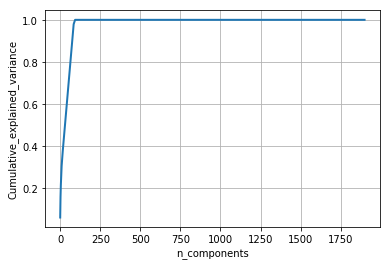

In [33]:
# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_expl_var, linewidth = 2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

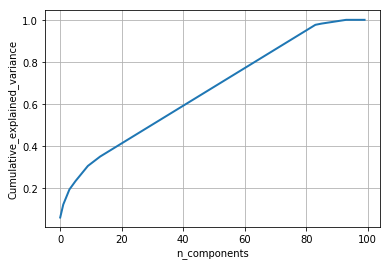

In [36]:
t_svd = TruncatedSVD(n_components=100)
t_svd_data = t_svd.fit_transform(df_temp)

variance_explained = t_svd.explained_variance_ratio_/np.sum(t_svd.explained_variance_ratio_)

cum_expl_var = np.cumsum(variance_explained)
# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_expl_var, linewidth = 2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [37]:
from sklearn.cluster import KMeans
def get_best_hyperparam(X):
    clf_score = []
    
    iterator = np.arange(1,10)
    for hyper in tqdm(iterator):
        clf = KMeans(n_clusters=hyper)
        clf.fit(X)
        clf_score.append([hyper, clf.inertia_])
        
    sns.lineplot([x[0] for x in clf_score], [x[1] for x in clf_score], \
             color ="blue")
    sns.scatterplot([x[0] for x in clf_score], [x[1] for x in clf_score], \
                 color ="red")
    
    plt.xlabel(f"K")
    plt.ylabel("Inertia")
    plt.title("Intertia vs K")
    plt.show()

100%|██████████| 9/9 [00:00<00:00, 19.66it/s]


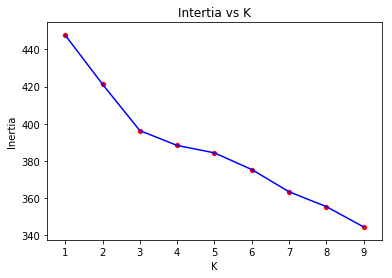

In [38]:
get_best_hyperparam(t_svd_data)

In [39]:
df_final = pd.DataFrame(t_svd_data)

In [40]:
df_final.shape

(2000, 100)

In [41]:
clf = KMeans(n_clusters=2)
clf.fit(t_svd_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [42]:
df_final["Cluster Label"] = clf.labels_
df_final["Features"] = df_temp.index
df_final.head(5)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,Cluster Label,Features
0,8.138811e-16,1.478476e-19,1.742514e-17,-7.817354e-19,3.217002e-18,3.339125e-18,-3.355100e-18,1.276313e-18,-1.114751e-18,2.656446e-18,...,4.943665e-18,2.338983e-17,0.0,0.0,0.0,0.0,0.0,0.0,0,zzzzzzzzzzz
1,-1.704016e-18,-9.925901e-19,-1.199099e-17,-2.444546e-17,-3.774120e-18,-7.509749e-18,2.198053e-18,-6.482115e-18,-3.875513e-17,1.108995e-17,...,-2.665718e-17,2.424062e-17,0.0,0.0,0.0,0.0,0.0,0.0,0,juiciness
2,-1.361924e-17,-5.823879e-18,-8.138891e-17,-1.510904e-16,5.622582e-17,-2.126497e-17,-1.724119e-16,1.353378e-16,6.387810e-18,-1.544127e-16,...,-6.282862e-19,-1.441241e-18,0.0,0.0,0.0,0.0,0.0,0.0,0,juicesrirachapepper
3,-1.036004e-17,2.852041e-18,-6.803196e-18,5.432344e-18,2.341822e-16,-1.198353e-16,-6.879064e-17,1.185444e-16,4.206832e-17,-2.404812e-18,...,9.018726e-18,-1.220716e-17,0.0,0.0,0.0,0.0,0.0,0.0,0,thoery
4,-7.827792e-19,-1.839462e-19,-9.384517e-18,-2.883429e-17,-1.126399e-16,-4.270645e-16,5.697136e-18,-4.150175e-16,-8.943295e-17,3.736858e-17,...,-2.887020e-18,3.081544e-19,0.0,0.0,0.0,0.0,0.0,0.0,0,juiceperfect


In [47]:
from wordcloud import WordCloud,STOPWORDS
def plot_word_cloud(topn_class, n, i):
    w_cloud = " ".join([x for x in topn_class][:20])
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 700, height = 500, background_color ='black', stopwords = STOPWORDS).generate(w_cloud) 

    # plot the WordCloud image                        
    plt.figure(figsize = (7, 5)) 
    plt.imshow(wordcloud, interpolation = 'bilinear') 
    plt.axis("off") 
    plt.title(f"Top {n} most important features of cluster {i}")
    plt.tight_layout(pad = 0) 
    plt.show()

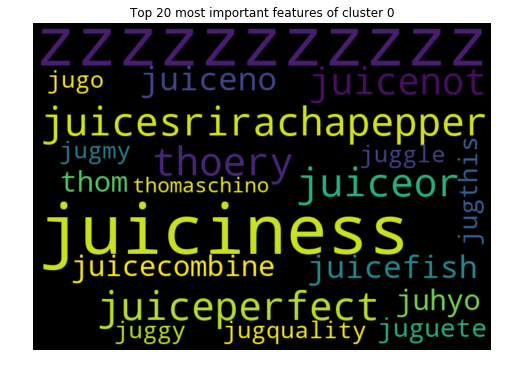

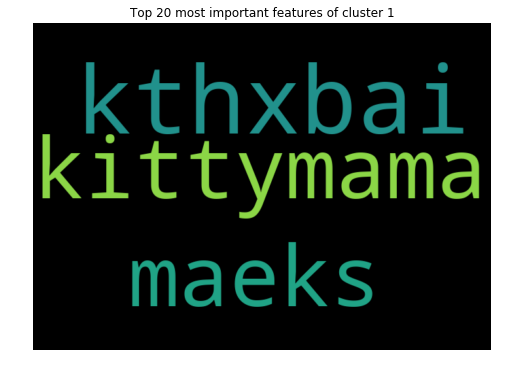

In [48]:
for i in range(clf.n_clusters):
    text = []
    words_per_cluster = df_final.groupby(["Cluster Label"]).groups[i]
    for j in range(len(words_per_cluster)):
        text.append(df_final.loc[words_per_cluster[j]]["Features"])
    plot_word_cloud(text, 20, i)

### Cosine Similarity

In [49]:
from sklearn.metrics import pairwise_distances

def cos_sim(word_idx, n):
    #Smaller distance=More similar word
    dist = pairwise_distances(t_svd_data, t_svd_data[word_idx:word_idx+1, :])
    #Index of distances
    indices = np.argsort(dist.flatten())[0:n]
    #The corresponding list of distances
    n_dist = np.sort(dist.flatten())[0:n]
    x = PrettyTable()
    df_idx = df_temp.index[indices].tolist()
    x.field_names=["Most Similar Word", "Distance"]
    for i in range(len(indices)):
        if indices[i]==df_final.index[indices[i]]:
            x.add_row([df_final["Features"].loc[indices[i]], dist[indices[i]]])
    print(x)

In [50]:
cos_sim(200, 10)

+-------------------+----------+
| Most Similar Word | Distance |
+-------------------+----------+
|        tish       |   [0.]   |
|      istewed      |   [0.]   |
|   ispowederized   |   [0.]   |
|      ispread      |   [0.]   |
|    ispronounced   |   [0.]   |
|      isquare      |   [0.]   |
|      isqueeze     |   [0.]   |
|      isquiet      |   [0.]   |
|       isreal      |   [0.]   |
|    isrefreshing   |   [0.]   |
+-------------------+----------+


In [51]:
cos_sim(130, 10)

+-------------------+----------+
| Most Similar Word | Distance |
+-------------------+----------+
|        tish       |   [0.]   |
|      istewed      |   [0.]   |
|   ispowederized   |   [0.]   |
|      ispread      |   [0.]   |
|    ispronounced   |   [0.]   |
|      isquare      |   [0.]   |
|      isqueeze     |   [0.]   |
|      isquiet      |   [0.]   |
|       isreal      |   [0.]   |
|    isrefreshing   |   [0.]   |
+-------------------+----------+


### Conclusions:

- On the 50k datapoints, tfidf vectorization was performed and on the basis of the IDF scores, top 2k features were taken

- The co occurrence matrix was then calculated and passed on to TruncatedSVD where variation uptill 100 components was observed.

- Similar features were clustered together with kmeans clustering and the cosine similarity was implemented to find similar words